# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research.

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples.

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [3]:
import os
os.getcwd()

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/w207/w207 Assignments')

In [6]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

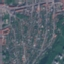

In [7]:
# Testing loading a random picture
load_img(os.path.join('./EuroSAT/Residential', 'Residential_286.jpg'))

In [8]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data

    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)

    '''
    ## load images and labels
    # FILL IN CODE HERE #

    # Initializing lists for images and labels
    images = []
    labels = []

    # Getting each image_class and their respective labels
    for image_class in os.listdir(DATA_PATH):

      # Defining path to specific image class folder
      image_class_path = os.path.join(DATA_PATH, image_class)

      for individual_image in tqdm(os.listdir(image_class_path)):
        image_path = os.path.join(image_class_path, individual_image)
        image = load_img(image_path)
        image_array = img_to_array(image)

        # Adding each image and label to the previous batch
        images.append(image_array)
        labels.append(image_class)

      print("Completed image_class:", image_class)

    # Converting to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    return images, labels

In [9]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

100%|██████████| 3000/3000 [01:12<00:00, 41.52it/s] 


Completed image_class: SeaLake


100%|██████████| 2000/2000 [00:40<00:00, 49.84it/s] 


Completed image_class: Pasture


100%|██████████| 2500/2500 [00:53<00:00, 47.16it/s] 


Completed image_class: River


100%|██████████| 2500/2500 [01:09<00:00, 36.06it/s] 


Completed image_class: PermanentCrop


100%|██████████| 3000/3000 [01:46<00:00, 28.30it/s] 


Completed image_class: Residential


100%|██████████| 2500/2500 [01:07<00:00, 37.02it/s] 


Completed image_class: Industrial


100%|██████████| 3001/3001 [01:49<00:00, 27.51it/s] 


Completed image_class: HerbaceousVegetation


100%|██████████| 3000/3000 [01:59<00:00, 25.03it/s] 


Completed image_class: AnnualCrop


100%|██████████| 2500/2500 [01:11<00:00, 34.96it/s] 


Completed image_class: Highway


100%|██████████| 3000/3000 [01:43<00:00, 28.85it/s] 


Completed image_class: Forest
Shape of images  (27001, 64, 64, 3)
Shape of labels  (27001,)


In [10]:
# Checking to see if HerbaceousVegetation really has 3001 images (it does):
len(os.listdir('./EuroSAT/HerbaceousVegetation'))

3001

---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

Note: It's acceptable to plot the distribution of classes before splitting your data into training, validation, and test sets. Doing so does not compromise the "blindness" of the test data. Why?

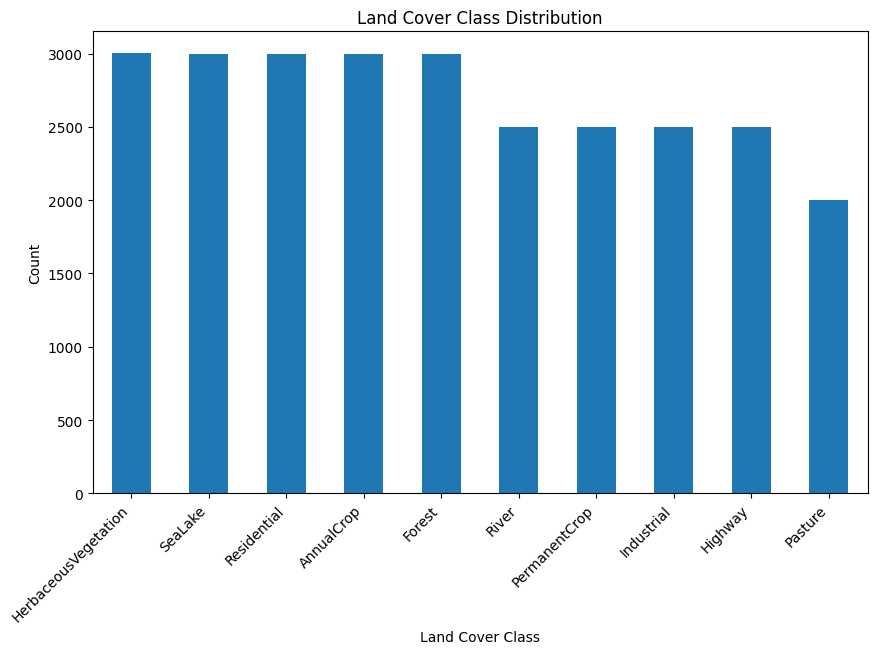

In [11]:
# FILL IN CODE HERE #

# Getting land cover class labels as a value_counts df (for easier plotting)
labels_counts = pd.DataFrame(labels, columns=['Class'])['Class'].value_counts()

# Plotting the land cover class distribution
plt.figure(figsize=(10, 6))
labels_counts.plot(kind='bar')
plt.xlabel("Land Cover Class")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.title("Land Cover Class Distribution")

plt.show()

Comment on class balance: The classes are roughly balanced, with most having either 2,500 or 3,000 (or 3,001 for HerbaceousVegetation) samples. The Pasture class is a bit low, with only 2,000 images, so it might be worthwhile to do some oversampling or undersampling to account for that.

Plotting the distribution of classes before splitting the data does not compromise the "blindness" of the test data because it does not expose specific test samples. All you're doing with the plotting is seeing aggregate statistics of the whole dataset, so you're not leaking any information. Furthermore, if your dataset is very imbalanced, plotting the class distribution can help you sample your data properly so that the training, validation, and test datasets all have the same class proportions (and therefore hopefully making your model more generalizable).

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

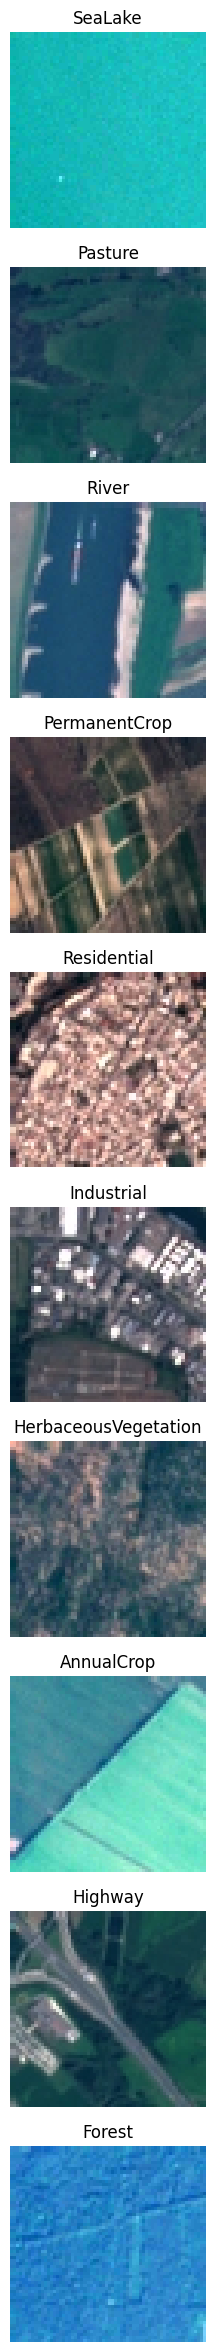

In [12]:
# FILL IN CODE HERE #

# Defining a label in df format for easier handling
label_df = pd.DataFrame(labels, columns=['Class'])

# Displaying the first image in images for each class in labels
fig, axs = plt.subplots(10, 1, figsize=(30, 30))

# Going through each class
for idx, image_class in enumerate(label_df['Class'].unique()):
  img = array_to_img(images[(label_df['Class'].values == image_class).argmax()])
  axs[idx].imshow(img)
  axs[idx].set_title(image_class)
  axs[idx].axis('off')

Most confused land classes: A Decision Tree classifier is more likely to confuse land classes with very similar features or colors. Depending on what features the decision tree classifier splits into its nodes, certain classes may be harder to distinguish than others. For example, SeaLake and River both seem to contain quite a bit of blue-colored water, and certain wide rivers might look like the sea (and vice versa). Similarly, the Pasture, HerbaceousVegetation, and even the AnnualCrop classes all have quite a bit of green, and depending on the images themselves, it may be hard to distinguish one from the other. Industrial and Residential might also be hard to distinguish, as they consist mostly of buildings with potentially similar color palettes. Lastly, one interesting thing to note is that the Forest class appears somewhat blue (at least in this image). Checking with other images confirms something similar, and it's unclear as to why this is the case (caveat: I'm colorblind, but it does still seem pretty blue even to me). The Decision Tree classifier may therefore mistake this as a river or sea.

---
### Step 3: Data preprocessing

Encode labels

In [13]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [14]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.

    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # shuffle data
    # FILL IN CODE HERE #
    indices = np.arange(images.shape[0])
    shuffled_indices = np.random.permutation(indices)
    images_shuffled = images[shuffled_indices]
    labels_shuffled = labels[shuffled_indices]

    # create data splits
    # FILL IN CODE HERE #
    X_train, X_val, y_train, y_val = train_test_split(
        images_shuffled, labels_shuffled, test_size = split[1] + split[2]
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_val, y_val, test_size = split[2] / (split[1] + split[2])
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

In [15]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of val labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of val labels  (5400,)
Shape of test images  (5401, 64, 64, 3)
Shape of test labels  (5401,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation.

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only:
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [16]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;

    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    data_partition (str): "train"

    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)

    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor


    # rescale image by dividing each pixel by 255.0
    # FILL IN CODE HERE #
    X = X / 255.0

    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): Adding augmented images to the training data is extremely important for model learning, as it's a way to make your model more generalizable while still utilizing the original training dataset and their corresponding labels. Specifically, adjusting the brightness, the contrast, flipping, or rotating the image slightly will help the model filter out the noise or the less important parts of the image (thereby allowing it to focus on the features that are actually relevant to the prediction). It will also better match "real world" scenarios, as gathering data is never perfect, and there will always be imperfections or variations in the data that the model will need to account for.

The reason we don't augment the validation and tests sets is because those are the datasets that we ultimately want to predict. Especially for the test dataset, we don't want to make any alterations to it, and we don't want any data leakage to happen by augmenting the data (even if we're not necessarily training on it). Furthermore, if we augment the validation or test datasets, when we perform hyperparameter tuning on our model, we might accidentally tune our model to certain features that appear more in the validation datasets (only because we augmented them), and there's a very good chance that it won't generalize well to a broader dataset.

In [17]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='test')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5401, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [16]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5401, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

In [23]:
### YOUR CODE HERE ###

# Setting argument values
n_estimators = 2  # Number of trees in forest
n_jobs = 1  # Number of jobs to run in parallel
random_state = 7
max_depth = 8  # Max depth of trees

# Creating a random forest from Sklearn
forest = ensemble.RandomForestClassifier(
    n_estimators=n_estimators,
    n_jobs=n_jobs,
    random_state=random_state,
    max_depth=max_depth
)

# Training the model on X_train_re and y_train
clf_forest = forest.fit(X_train_re, y_train)

# Evaluating the accuracy of the model for the training and validation datasets
print ('Accuracy on training data:', clf_forest.score(X_train_re, y_train))
print ('Accuracy on validation data:', clf_forest.score(X_val_re, y_val))

Accuracy on training data: 0.48052469135802467
Accuracy on validation data: 0.4437037037037037


Comment on model accuracy on training vs. validation data: The model training accuracy is not great, sitting below 50%. The accuracy of the validation data is even worse, at around 44%. If we're comparing these values with a baseline of the majority class (which should be ~11%), the accuracies do look substantially better. However, the model would still recognize more than half of the images incorrectly.

Does the model generalize well?: With its poor training accuracy and even worse validation accuracy, the model does not do a great job generalizing. This does make some sense, as even though a random forest is supposed to mitigate the generalization problem of decision trees, there are only 2 trees in this current forest. Therefore, this problem still largely exists, and the model likely overfits on the training dataset, with all its noise and potentially irrelevant data.

In [31]:
# Getting y_val_pred
y_val_pred = clf_forest.predict(X_val_re)

# Getting the confusion matrix using y_val and y_val_pred
cf = confusion_matrix(
    y_val,
    y_val_pred
)

print('Generating the confusion matrix using confusion_matrix from '
  'sklearn.metrics:')
cf

Generating the confusion matrix using confusion_matrix from sklearn.metrics:


array([[232,   7, 105,   7,  16,  24,  83,  63,  23,  25],
       [  0, 472,   3,   0,   0,  24,   0,   6,   7,  95],
       [ 41,  14, 254,   4,  14,  38,  84, 122,  21,   8],
       [ 51,  36,  88,  17,  12,  61,  29, 126,  74,  21],
       [ 51,   0,  35,   3, 214,   9,  30, 147,   1,   8],
       [  3,  25,  69,   0,   1, 207,   0,  26,  39,  44],
       [110,   2, 121,   3,   6,  17, 113, 103,   4,   5],
       [ 39,   2, 116,   8,  28,  27,  56, 289,  12,  10],
       [ 15,  51,  48,  16,   5,  69,   9,  94, 155,  44],
       [  2,  58,  28,   1,   0,  30,   1,  31,  10, 443]])

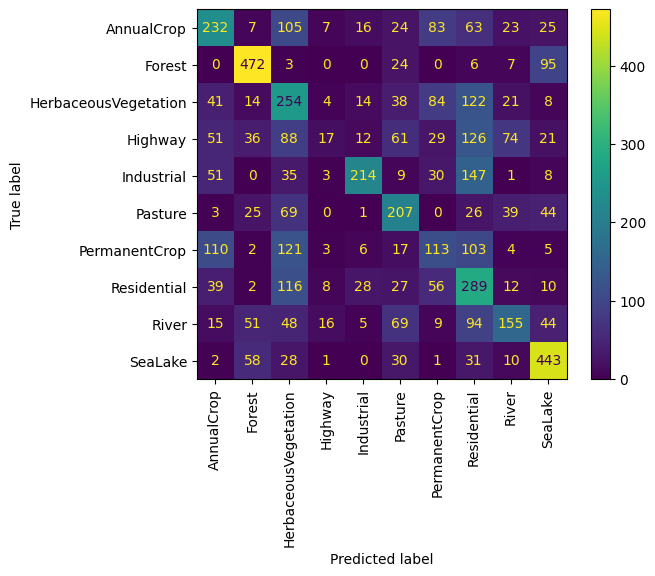

In [32]:
# Plotting the confusion matrix (getting vertical xticks)
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_val,
    y_pred=y_val_pred,
    labels=None,
    display_labels=encoded_labels_classes,
    xticks_rotation='vertical'
)

In [33]:
# Getting the precision and recall scores:
precision = sklearn.metrics.precision_score(y_val, y_val_pred, average=None)
recall = sklearn.metrics.recall_score(y_val, y_val_pred, average=None)

print("Determining precision for each class:")
print(precision, '\n')
print("Determining recall for each class:")
print(recall, '\n')
print("With the classes corresponding to the respective labels below:")
print(encoded_labels_classes)

Determining precision for each class:
[0.42647059 0.70764618 0.29296424 0.28813559 0.72297297 0.40909091
 0.27901235 0.28699106 0.44797688 0.63015647] 

Determining recall for each class:
[0.3965812  0.77759473 0.42333333 0.03300971 0.42971888 0.5
 0.23347107 0.4923339  0.30632411 0.73344371] 

With the classes corresponding to the respective labels below:
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Comment on the classes that the model confuses the most: In terms of the precision (TP / (TP+FP)), or how "right" the model's predictions are for any particular predicted label, the model seems to confuse PermanentCrop the most, with a precision of only 0.279. In other words, when the model predicts PermanenetCrop, only ~28% of the time will it actually be a PermanentCrop. Looking at the pictures above, this somewhat makes sense, as there seems to be a lot of green and quite a few "grid-like" features, making this class easily confusable with any of the other "greener" classes or either the "Industrial" or "Residential" classes.

In terms of the recall (TP / TP+FN)), or how well the model can correctly identify any true label, Highway seems by far the worst, with a recall of just 0.033. In other words, when given a true label for Highway, the model will only classify it as such ~3% of the time. Looking at the previous pictures, this also makes quite a bit of sense, as highways can naturally fit between any sort of geography, whether it be in a city with lots of people, or in a greener area that's less dense with more pasture or vegetation. In essence, Highway might not have any particularly distinct features, and the classifier may have prioritized other features with higher information gain, which made it so that Highway got clumped in with some other classes.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the training and validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). Also, the performance difference between the training and validation sets should be at most 10%. Be sure to follow these guidelines:
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

In [3]:
# For deeper explanation on pre-processing, please see my response below this
# section. However, I basically just did the data augmentation step in a
# different order, and I created new training, validation, and test datasets to
# do so.

In [17]:
# Creating improved training, validation, and test datasets
X_train_i, y_train_i, X_val_i, y_val_i, X_test_i, y_test_i = split_data(
    images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train_i.shape)
print('Shape of train labels ', y_train_i.shape)

print('Shape of val images ', X_val_i.shape)
print('Shape of val labels ', y_val_i.shape)

print('Shape of test images ', X_test_i.shape)
print('Shape of test labels ', y_test_i.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of val labels  (5400,)
Shape of test images  (5401, 64, 64, 3)
Shape of test labels  (5401,)


In [18]:
def data_preprocessing_improved(X, y, data_partition='train'):

    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # FIRST rescaling image by dividing each pixel by 255.0
    X = X / 255.0

    # THEN performing image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor

    return X, y

In [19]:
# Performing data preprocessing (improved, or "i", versions)
X_train_i, y_train_i = data_preprocessing_improved(X_train_i, y_train_i, data_partition='train')
X_val_i, y_val_i = data_preprocessing_improved(X_val_i, y_val_i, data_partition='val')
X_test_i, y_test_i = data_preprocessing_improved(X_test_i, y_test_i, data_partition='test')

# Printing shapes of improved datasets (should be the same)
print('Shape of improved train images ', X_train_i.shape)
print('Shape of improved train labels ', y_train_i.shape)
print('Shape of improved val images ', X_val_i.shape)
print('Shape of improved test images ', X_test_i.shape)

Shape of improved train images  (32400, 64, 64, 3)
Shape of improved train labels  (32400,)
Shape of improved val images  (5400, 64, 64, 3)
Shape of improved test images  (5401, 64, 64, 3)


In [20]:
# Reshaping the improved data
X_train_re_i = X_train_i.reshape(X_train_i.shape[0], features_shape)
X_val_re_i = X_val_i.reshape(X_val_i.shape[0], features_shape)
X_test_re_i = X_test_i.reshape(X_test_i.shape[0], features_shape)

# print shapes
print('Shape of improved train images ', X_train_re_i.shape)
print('Shape of improved train labels ', y_train_i.shape)
print('Shape of improved val images ', X_val_re_i.shape)
print('Shape of improved test images ', X_test_re_i.shape)

Shape of improved train images  (32400, 12288)
Shape of improved train labels  (32400,)
Shape of improved val images  (5400, 12288)
Shape of improved test images  (5401, 12288)


In [22]:
rf_clf2 = ''
### YOUR CODE HERE ###

# Setting improved argument values
n_estimators_2 = 40
n_jobs_2 = 2
random_state_2 = 7
max_depth_2 = 8

# Creating the improved random forest model
forest_2 = ensemble.RandomForestClassifier(
    n_estimators=n_estimators_2,
    n_jobs=n_jobs_2,
    random_state=random_state_2,
    max_depth=max_depth_2
)

# Training the improved model on X_train_re and y_train
rf_clf2 = forest_2.fit(X_train_re_i, y_train)

# Evaluating the improved accuracy of the model
print ('Accuracy on training data:', rf_clf2.score(X_train_re_i, y_train))
print ('Accuracy on validation data:', rf_clf2.score(X_val_re_i, y_val))

Accuracy on training data: 0.5925
Accuracy on validation data: 0.5448148148148149


How your implementation is different compared to the baseline classifier: I tried a number of different implementations, including setting different argument values from the baseline model and performing a different data-processing step. For the different arguments, I ultimately landed on increasing the number of estimators (trees) to 40, which should hopefully make the model more generalizable by taking different features and running a decision tree on each. I also increased the n_jobs to 2 to make the model run faster. Lastly, while I changed the max_depth a few times, decreasing it made the model worse, and increasing it made the model take much longer to run, without seemingly much improvement. Therefore, I opted to keep the current max_depth at 8.

For the data pre-processing, I noticed that we are changing the DELTA (the brightness) before normalization. However, the DELTA is simply added to the pixels (which are still from 0-255), and it's pre-set to 0.3. Thus, the augmented images really didn't change all that much; so instead, I performed the normalization step first, and THEN I changed the DELTA, which should hopefully give much more different images (of different varieties) for the model to learn.

In [25]:
# Evaluating the model's accuracy on the data

print("The improved model's accuracies for the training and validation data")
print("are both better than those of the baseline model. This makes quite a")
print("bit of sense, as we used more trees, which made our model be able to")
print("see and evaluate more features more times, which also makes it more")
print("generalizable. Speaking of which, while the generalization still wasn't")
print("great, it's at least comparable to the difference in the baseline")
print("model. This might be able to be improved further, perhaps by decreasing")
print("the depth while increasing the number of trees to maximize")
print("generalizability.")

The improved model's accuracies for the training and validation data
are both better than those of the baseline model. This makes quite a
bit of sense, as we used more trees, which made our model be able to
see and evaluate more features more times, which also makes it more
generalizable. Speaking of which, while the generalization still wasn't
great, it's at least comparable to the difference in the baseline
model. This might be able to be improved further, perhaps by decreasing
the depth while increasing the number of trees to maximize
generalizability.


In [30]:
# Commenting on the training vs. val performance relative to baseline model

# Getting the scores
baseline_train_acc = clf_forest.score(X_train_re, y_train)
baseline_val_acc = clf_forest.score(X_val_re, y_val)
improved_train_acc = rf_clf2.score(X_train_re_i, y_train)
improved_val_acc = rf_clf2.score(X_val_re_i, y_val)

print("Baseline accuracy on the training data:", baseline_train_acc)
print("Baseline accuracy on the validation data:", baseline_val_acc, "\n")

print("Improved model accuracy on the training data:", improved_train_acc)
print("Improved model accuracy on the validation data:", improved_val_acc, "\n")

print("Difference in training data accuracies for the improved model compared")
print("to the baseline model:", improved_train_acc - baseline_train_acc, "\n")
print("Difference in val data accuracies for the improved model compared to")
print("the baseline model:", improved_val_acc - baseline_val_acc, "\n")
print("Difference between improved model's training and validation accuracies")
print("(should be at most 10%):", improved_train_acc - improved_val_acc)

Baseline accuracy on the training data: 0.48052469135802467
Baseline accuracy on the validation data: 0.4437037037037037 

Improved model accuracy on the training data: 0.5925
Improved model accuracy on the validation data: 0.5448148148148149 

Difference in training data accuracies for the improved model compared
to the baseline model: 0.11197530864197536 

Difference in val data accuracies for the improved model compared to
the baseline model: 0.10111111111111115 

Difference between improved model's training and validation accuracies
(should be at most 10%): 0.047685185185185164


Comment on training vs. validation performance relative to baseline model: The training and validation performance in terms of accuracy are both higher than those of the baseline model. As explained above, this makes quite a bit of sense, as the greater number of trees likely allowed our model to be able to see and evaluate more features more times, thereby making it more generalizable.

We have also fulfilled the requirement of having the improved model's training and validation accuracies be at least 10% greater than those of the baseline. Moreover, we have kept the difference in training and validation accuracies of the improved model to below 5%, which also met the 10% threshold.

In [36]:
# Getting y_val_pred_i for the improved model
y_val_pred_i = rf_clf2.predict(X_val_re_i)

# Getting the confusion matrix using y_val and y_val_pred_i
cf_i = confusion_matrix(
    y_val,
    y_val_pred_i
)

print('Generating the confusion matrix using confusion_matrix from '
  'sklearn.metrics:')
cf_i

Generating the confusion matrix using confusion_matrix from sklearn.metrics:


array([[358,   7,  29,   9,  30,  14,  22,  50,  54,  12],
       [  0, 544,   1,   0,   0,  34,   0,   7,   8,  13],
       [ 99,  13, 234,   8,  17,  13,  42, 130,  41,   3],
       [ 64,  36,  28,  56,  21,  32,   9, 124, 137,   8],
       [ 29,   3,  15,   1, 333,   0,   7, 100,   7,   3],
       [  0,  16,  54,   1,   1, 228,   0,  36,  39,  39],
       [170,   0,  91,   2,  15,  10,  71, 112,  13,   0],
       [ 43,   0,  51,   4,  51,   3,  24, 390,  21,   0],
       [ 18,  47,  14,  20,  17,  16,   1,  60, 299,  14],
       [  0,  62,  20,   0,   0,  19,   6,  33,  35, 429]])

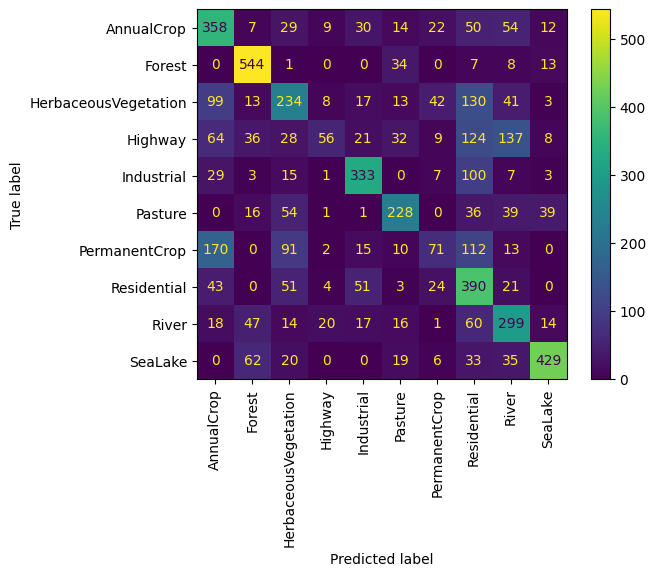

In [38]:
# Plotting the confusion matrix for the improved model (getting vertical xticks)
disp_i = ConfusionMatrixDisplay.from_predictions(
    y_true=y_val,
    y_pred=y_val_pred_i,
    labels=None,
    display_labels=encoded_labels_classes,
    xticks_rotation='vertical'
)

In [39]:
# Getting the precision and recall scores:
precision_i = sklearn.metrics.precision_score(y_val, y_val_pred_i, average=None)
recall_i = sklearn.metrics.recall_score(y_val, y_val_pred_i, average=None)

print("Determining improved precision for each class:")
print(precision_i, '\n')
print("Determining improved recall for each class:")
print(recall_i, '\n')
print("With the classes corresponding to the respective labels below:")
print(encoded_labels_classes)

Determining improved precision for each class:
[0.45838668 0.74725275 0.43575419 0.55445545 0.68659794 0.61788618
 0.39010989 0.37428023 0.45718654 0.82341651] 

Determining improved recall for each class:
[0.61196581 0.89621087 0.39       0.10873786 0.6686747  0.55072464
 0.14669421 0.66439523 0.59090909 0.7102649 ] 

With the classes corresponding to the respective labels below:
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Comment on the classes the model confuses the most relative to the baseline: In terms of the precision (TP / (TP+FP)), or how "right" the model's predictions are for any particular predicted label, the model seems to confuse Residential the most, with a precision of only 0.374. In other words, when the model predicts Residential, only ~37% of the time will it actually be a Residential. Looking at the pictures above, this still somewhat makes sense, as Residential seems to have some grid-like features, with potentially some green scattered in there as well, making this potentially confusable with the "Industrial", "HerbaceousVegetation", or "Highway" classes.

In terms of the recall (TP / TP+FN)), or how well the model can correctly identify any true label, Highway still seems to be the worst, with a recall of just 0.109. In other words, when given a true label for Highway, the model will only classify it as such ~11% of the time. The reasoning is pretty much the same with the previous section's, where highways can naturally fit between any sort of geography, whether it be in a city with lots of people, or in a greener area that's less dense with more pasture or vegetation. In essence, Highway might not have any particularly distinct features, and the classifier may have prioritized other features with higher information gain, which made it so that Highway got clumped in with some other classes.

Comparing these easily-confusable classes with those of the baseline, we see that they're pretty similar. Highway still has the worst recall, and PermanentCrop actually has the second worst precision in the improved model. This still seems to make quite a bit of sense, as our input data really didn't change that much, and even though our improved model may be more generalizable, we still can only work with what we have.

One positive side to it, however, is that our lowest recall and precision scores for the improved model are both higher than those of the baseline model. This gives us confidence that our improved is indeed better, and it will more often than not outperform the baseline model.

In [46]:
print("When reading the instructions, one thing to note is that this exercise")
print("asks us to train and evaluate the model on X_train_re and X_val_re")
print("specifically. For clarification, I renamed my variables to X_train_re_i")
print("and X_val_re_i to signify the difference between the baseline and the")
print("improved models. X_val_re_i is actually the same as X_val_re, as the")
print("the normalization step is the same, and it doesn't go through the if-")
print("statement. The difference between X_train_re_i and X_train_re is only")
print("the order in which the augmentation and normalization steps take place,")
print("as described above. In the original model, the augmentation steps occur")
print("before the normalization step, and with the pre-specified DELTA of 0.3,")
print("I did not believe it had that large of an effect on the pixel values.")
print("Changing up the order allowed the DELTA to have a much larger effect,")
print("which I believe contributed to the generalizability of the improved")
print("model. Therefore, I opted to use X_val_re_i instead, which was also")
print("mentioned in the problem statement ('different data preprocessing")
print("procedure'). Nevertheless, I still want to see how well my model does")
print("with the original dataset, so here we go:")

When reading the instructions, one thing to note is that this exercise
asks us to train and evaluate the model on X_train_re and X_val_re
specifically. For clarification, I renamed my variables to X_train_re_i
and X_val_re_i to signify the difference between the baseline and the
improved models. X_val_re_i is actually the same as X_val_re, as the
the normalization step is the same, and it doesn't go through the if-
statement. The difference between X_train_re_i and X_train_re is only
the order in which the augmentation and normalization steps take place,
as described above. In the original model, the augmentation steps occur
before the normalization step, and with the pre-specified DELTA of 0.3,
I did not believe it had that large of an effect on the pixel values.
Changing up the order allowed the DELTA to have a much larger effect,
which I believe contributed to the generalizability of the improved
model. Therefore, I opted to use X_val_re_i instead, which was also
mentioned in the pr

In [47]:
# Still keeping the same improved random forest model for X_train_re
forest_3 = ensemble.RandomForestClassifier(
    n_estimators=n_estimators_2,
    n_jobs=n_jobs_2,
    random_state=random_state_2,
    max_depth=max_depth_2
)

# Training the improved model on X_train_re and y_train
rf_clf3 = forest_3.fit(X_train_re, y_train)

# Evaluating the improved accuracy of the model
print ('Accuracy on training data:', rf_clf3.score(X_train_re, y_train))
print ('Accuracy on validation data:', rf_clf3.score(X_val_re, y_val))

Accuracy on training data: 0.625216049382716
Accuracy on validation data: 0.5366666666666666


The model training accuracy for the original X_train_re dataset, at ~62.5%, actually surpasses the accuracy when using the improved dataset to build the model. However, the validation accuracy is worse, sitting at ~53.6%. Thus, even though this training data and model had a higher accuracy, the generalizability of this model is worse. This can probably be attributed to overfitting, as the similarities in the images probably caused this model to not have as good of separation as the previous improved model.

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the training and validation sets?

In [50]:
### YOUR CODE HERE ###

# I shall use the improved model (rf_clf2) trained on the improved dataset
improved_test_acc = rf_clf2.score(X_test_re_i, y_test)
print("Accuracy on test data:", improved_test_acc)
print("Accuracy of validation data:", improved_val_acc)
print("Accuracy of training data:", improved_train_acc)
print("Difference between test and val accuracies:",
      improved_test_acc - improved_val_acc)

Accuracy on test data: 0.5384188113312349
Accuracy of validation data: 0.5448148148148149
Accuracy of training data: 0.5925
Difference between test and val accuracies: -0.006396003483579937


Comment on test set accuracy vs. training vs. validation set accuracy: The test accuracy is pretty comparable to the validation accuracy, being only 0.6% apart. Thus, similar to the previous discussion, this makes our model pretty generalizable, as it does decently well with the training dataset, but also performs not too much worse on both the validation and testing datasets.

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

In [59]:
### YOUR ANSWER HERE ###

print("I would say this greatly depends on what is currently out there and")
print("what baseline I'm comparing this model to. For example, if there's")
print("currently no other models out there for land cover classification, and")
print("we set our baseline to just be the majority class, then of course the")
print("Decision Forest outperforms the majority class classifier greatly.")
print("However, if there's another model out there that already has an")
print("accuracy of 90% let's say, then this current Decision Forest model")
print("would be substantially worse. Perhaps more training can be done with")
print("more trees or a greater depth, but it's doubtful that a Decision Forest")
print("alone can improve all the way to 90% accuracy.\n")

print("Along similar lines, another reason why I would not recommend this")
print("model for land cover classification is because it takes a lot of memory")
print("and processing power to run. Even with these relatively simple models,")
print("it still took quite a few minutes to run, and the more trees we add")
print("(and the greater the depth we go to), it's going to take exponentially")
print("more compute power to get through everything. It may be the case that")
print("we do have the resources necessary to perform such a task, but we would")
print("also need to consider our dataset. We're currently training on 32,400")
print("images, but what if we have 1 million? There are definitely more")
print("pictures that exist out there, and the more we add, the longer this")
print("model would take to run.\n")

print("One last thing to note is that a decision tree (and also a forest)")
print("classifies the different inputs based on information gain and then")
print("boundaries to separate the child nodes. It does not try to 'learn'")
print("edges or patterns the same way a DNN does, and different types of data")
print("may affect the performance greatly. To truly classify these images, I")
print("would contend that using a DNN would give more accurate results, even")
print("if it comes at the cost of a longer training time in the beginning, or")
print("a lack of understandability in the model.")

I would say this greatly depends on what is currently out there and
what baseline I'm comparing this model to. For example, if there's
currently no other models out there for land cover classification, and
we set our baseline to just be the majority class, then of course the
Decision Forest outperforms the majority class classifier greatly.
However, if there's another model out there that already has an
accuracy of 90% let's say, then this current Decision Forest model
would be substantially worse. Perhaps more training can be done with
more trees or a greater depth, but it's doubtful that a Decision Forest
alone can improve all the way to 90% accuracy.

Along similar lines, another reason why I would not recommend this
model for land cover classification is because it takes a lot of memory
and processing power to run. Even with these relatively simple models,
it still took quite a few minutes to run, and the more trees we add
(and the greater the depth we go to), it's going to take ex

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

In [72]:
### YOUR ANSWER HERE ###

print("As mentioned in the previous exercise, I would propose a DNN (deep")
print("neural network) to try improving the performance. More specifically,")
print("I believe that a multinomial logistic regression using the same inputs")
print("with some hidden layers and hyperparameter tuning will be better. Even")
print("more specifically, our input features would be the normalized and")
print("flattened pixel values, and we can use the augmented features as well.")

print("\nOne caveat I can foresee is that if we do go with the strategy above,")
print("there might be too many features (12288) for a model with many hidden")
print("layers to run effectively. Thus, perhaps resizing the images will be")
print("necessary if the pictures are currently too large.")

As mentioned in the previous exercise, I would propose a DNN (deep
neural network) to try improving the performance. More specifically,
I believe that a multinomial logistic regression using the same inputs
with some hidden layers and hyperparameter tuning will be better. Even
more specifically, our input features would be the normalized and
flattened pixel values, and we can use the augmented features as well.

One caveat I can foresee is that if we do go with the strategy above,
there might be too many features (12288) for a model with many hidden
layers to run effectively. Thus, perhaps resizing the images will be
necessary if the pictures are currently too large.


----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [63]:
print("After trying to implement the exact idea proposed in Exercise 10, I")
print("realized there were too many observations, and using hidden layers with")
print("them was unfeasible (too many parameters). Therefore, I'm opting to")
print("resize the image down and try again.")

After trying to implement the exact idea proposed in Exercise 10, I
realized there were too many observations, and using hidden layers with
them was unfeasible (too many parameters). Therefore, I'm opting to
resize the image down and try again.


In [60]:
# Resizing images in X_train (called X_train_s, or X_train small)
X_train_s = tf.image.resize(X_train, size=(32, 32)).numpy()

# Confirming the shape of X_train
X_train_s.shape

(32400, 32, 32, 3)

In [74]:
print("After testing sizes of 64x64 and 16x16, I landed on 32x32 as an")
print("appropriate picture size. This isn't so big that I'll run out of ram,")
print("but it isn't so small as to lose a lot of granularity. I will move")
print("forward with this 32x32 image, and I'll try altering the different")
print("hyperparameters in the DNN to improve the model.")

After testing sizes of 64x64 and 16x16, I landed on 32x32 as an
appropriate picture size. This isn't so big that I'll run out of ram,
but it isn't so small as to lose a lot of granularity. I will move
forward with this 32x32 image, and I'll try altering the different
hyperparameters in the DNN to improve the model.


In [61]:
# Resizing for X_val and X_test
X_val_s = tf.image.resize(X_val, size=(32, 32)).numpy()
X_test_s = tf.image.resize(X_test, size=(32, 32)).numpy()

In [83]:
# Creating a function to build a DNN logistic regression model
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01,
                metric='metric',
                image_size=32):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Setting up Sequential model
    model = tf.keras.Sequential()

    # Adding in input layer
    model.add(tf.keras.Input(shape=(image_size, image_size, 3), name='Input'))

    # Flattening the input layer
    model.add(tf.keras.layers.Flatten(name='Flatten'))

    # Adding in hidden layers
    for idx, hidden_layer_size in enumerate(hidden_layer_sizes):
      model.add(tf.keras.layers.Dense(
          units=hidden_layer_size,
          activation=activation,
          name='Hidden'+str(idx)
      ))

    # Adding dropout layer
    model.add(tf.keras.layers.Dropout(rate=0.3, name='Dropout'))

    # Adding output layer
    model.add(tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        name='Output'
    ))

    # Setting specific learning rate
    optimizer_class = getattr(tf.keras.optimizers, optimizer)
    optimizer_true = optimizer_class(learning_rate=learning_rate)

    # Compiling the model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=optimizer_true,
        metrics=[metric]
    )

    return model

Quick explanation of the model above: It allows me to change different hyperparameters depending on how I want to tune the model. However, the base will always be the same: first an input layer, then a flattening layer, then XX number of hidden layers with their respective nodes, then a dropout layer for better generalization, and finally the output layer with softmax for multi-class classification.

In [84]:
# Getting the function to run experiments
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       metric='accuracy',
                       num_epochs=10,
                       batch_size=64,
                       image_size=32):

  # Build the model.
    model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      metric=metric,
                      learning_rate=learning_rate,
                      image_size=image_size)
    print(model.summary())

  # Choose the appropriate dataset
    if image_size == 32:
        X_train_actual = X_train_s
        X_val_actual = X_val_s
    elif image_size == 64:
        X_train_actual = X_train
        X_val_actual = X_val

  # Train the model.
    print('Training the model...')
    history = model.fit(
        x=X_train_actual,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=[X_val_actual, y_val],
        verbose=1)

    # Retrieve the training metrics (after each train epoch) and the final validation
    # accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    print('Training accuracy: %1.4f' %train_accuracy[-1])
    print('Validation accuracy: %1.4f' %val_accuracy[-1])

    return model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │          30,730 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Training the model...


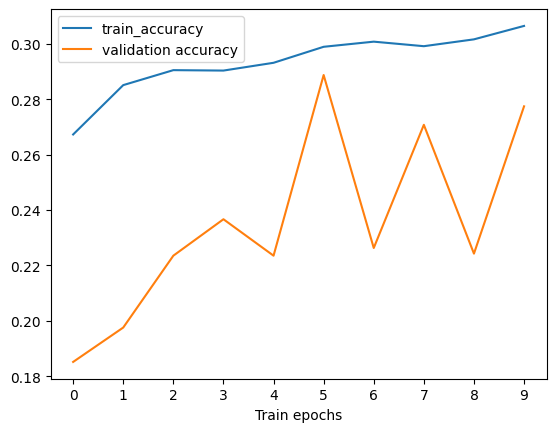

Training accuracy: 0.3064
Validation accuracy: 0.2774


<Sequential name=sequential, built=True>

In [65]:
# Running an initial model with default parameters:
train_and_evaluate()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 256)                 │         786,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 789,258 (3.01 MB)

 Trainable params: 789,258 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

None
Training the model...
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2355 - loss: 2.0694 - val_accuracy: 0.3157 - val_loss: 1.7947
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3439 - loss: 1.7569 - val_accuracy: 0.3904 - val_loss: 1.7033
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3727 - loss: 1.6716 - val_accuracy: 0.4294 - val_loss: 1.6395
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4038 - loss: 1.6068 - val_accuracy: 0.4398 - val_loss: 1.5908
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4339 - loss: 1.5474 - val_accuracy: 0.4644 - val_loss: 1.5491
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4527 - loss: 1.5080 - val_accuracy: 0.4696 - val_loss: 1.5161
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4656 - loss: 1.4691 - val_accuracy: 0.4691 - val_loss: 1.5054
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0

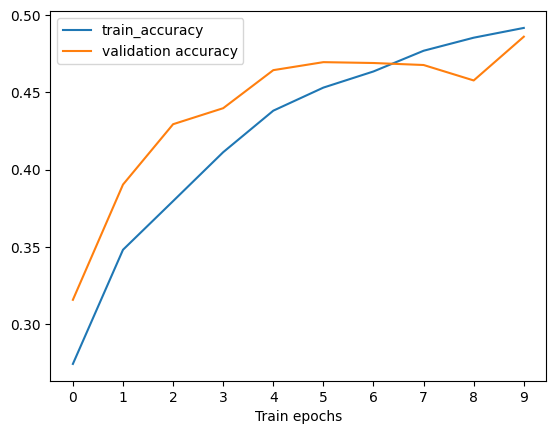

Training accuracy: 0.4918
Validation accuracy: 0.4861


In [73]:
# Testing more options for models
model_dnn = train_and_evaluate(hidden_layer_sizes=[256],
  activation='relu', optimizer='Adam', learning_rate=0.0001)

This model above was pretty good; I chose the first hidden layer as 256 because I wanted to replicate a 16x16 image. I also decreased the learning rate to 0.0001, as I thought it was going too fast previously and diverging. Using relu as the hidden layer activation and Adam as the optimizer are standard as well, and those should be fine.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 256)                 │         786,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden2 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 804,346 (3.07 MB)

 Trainable params: 804,346 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Training the model...
Epoch 1/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1900 - loss: 2.1718 - val_accuracy: 0.2552 - val_loss: 1.9901
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2429 - loss: 2.0222 - val_accuracy: 0.2841 - val_loss: 1.8833
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2901 - loss: 1.9210 - val_accuracy: 0.3494 - val_loss: 1.8142
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3126 - loss: 1.8681 - val_accuracy: 0.3878 - val_loss: 1.7652
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3376 - loss: 1.8272 - val_accuracy: 0.3870 - val_loss: 1.7348
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3563 - loss: 1.7793 - val_accuracy: 0.4065 - val_loss: 1.7098
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3648 - loss: 1.7524 - val_accuracy: 0.4278 - val_loss: 1.6865
Epoch 8/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.376

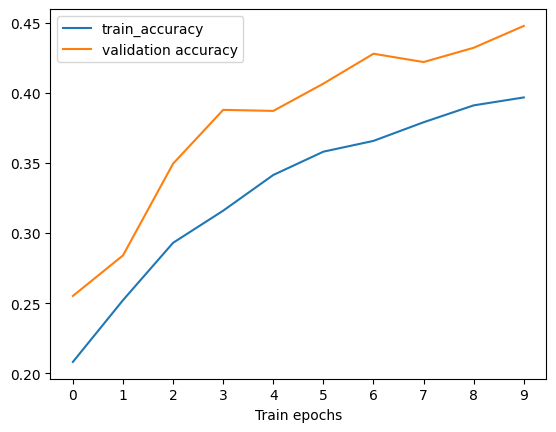

Training accuracy: 0.3966
Validation accuracy: 0.4476


In [78]:
# Testing more options for the model
model_dnn_2 = train_and_evaluate(hidden_layer_sizes=[256, 64, 16],
  activation='relu', optimizer='Adam', learning_rate=0.0001, batch_size=128)

I tried a number of other models with more hidden layers of different sizes. For the model above, I wanted to simulate going from a 32x32 image to a 16x16 image to an 8x8 iamge to a 4x4 image. Unfortunately, that didn't work, so I might switch gears.

I think my computer can barely handle 64x64 pixels, so I'm going to alter the code above to be able to handle the 64x64 image (if it so chooses), but still with the default as 32x32.

In [92]:
# Checking to see what variables are in memory so I can delete them
%who

ConfusionMatrixDisplay	 DATA_PATH	 ImageDataGenerator	 LabelEncoder	 X_test	 X_train	 X_val	 accuracy_score	 array_to_img	 
axs	 build_model	 confusion_matrix	 data_preprocessing	 drive	 encoded_labels	 encoded_labels_classes	 encoder	 ensemble	 
fig	 idx	 image_class	 images	 img	 img_to_array	 label_df	 labels	 labels_counts	 
load_data	 load_img	 np	 os	 pathlib	 pd	 plt	 random	 shutil	 
sklearn	 sns	 split	 split_data	 tf	 tfds	 tqdm	 train_and_evaluate	 train_test_split	 
warnings	 y_test	 y_train	 y_val	 


In [102]:
# Deleting images and labels from memory (since they're no longer needed)
# del images
# del labels

# (Can also delete the 32x32 small X data since we're not using that anymore)
# del X_train_s
# del X_val_s
# del X_test_s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)                    │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden0 (Dense)                      │ (None, 256)                 │       3,145,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden2 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,163,642 (12.07 MB)

 Trainable params: 3,163,642 (12.07 MB)

 Non-trainable params: 0 (0.00 B)

None
Training the model...
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.1490 - loss: 2.2593 - val_accuracy: 0.1026 - val_loss: 2.1241
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.1838 - loss: 2.1241 - val_accuracy: 0.1730 - val_loss: 2.0285
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.2135 - loss: 2.0605 - val_accuracy: 0.2472 - val_loss: 1.9860
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - accuracy: 0.2368 - loss: 2.0169 - val_accuracy: 0.2444 - val_loss: 1.9395
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.2630 - loss: 1.9663 - val_accuracy: 0.2909 - val_loss: 1.8792
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.2782 - loss: 1.9264 - val_accuracy: 0.3054 - val_loss: 1.8456
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.2816 - loss: 1.8994 - val_accuracy: 0.3113 - val_loss: 1.8322
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.2948

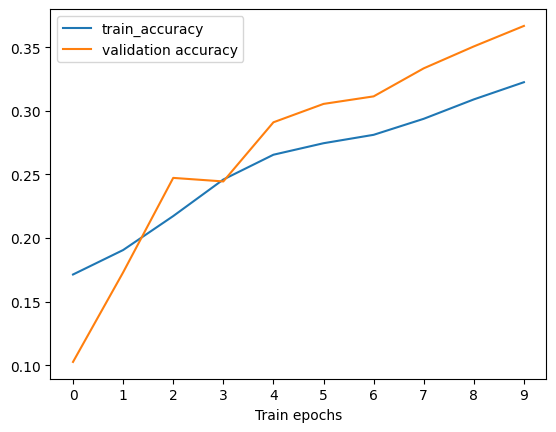

Training accuracy: 0.3224
Validation accuracy: 0.3667


In [113]:
# Testing more options for models
model_dnn_3 = train_and_evaluate(hidden_layer_sizes=[256, 64, 16],
  activation='relu', optimizer='Adam', learning_rate=0.0001, batch_size=512,
  image_size=64)

After trying with the 64x64 image, while it can run, the model never finishes running through all the epochs without crashing. The best parameters I can input are shown above, with a large batch size of 512 and the same hidden layer sizes as the previous 32x32 model [256, 64, 16]. However, even though I probably could've increased the number of epochs, the model actually performed worse.

My hypothesis is because the positions of the pixels of the images are not scaled properly; more specifically, we have RGB for the 64x64x3 image, but when it gets flattened, the pixel "locations" actually get spread out a lot. Thus, if we convert to grayscale and get a 64x64x1 image, it might work better, as the positions will remain intact.

In [115]:
# Deleting model_dnn_3 from memory
# del model_dnn_3

In [ ]:
# Getting the X data into greyscale format after re-scaling back up
X_train_g = tf.image.rgb_to_grayscale(X_train*255.0)
X_val_g = tf.image.rgb_to_grayscale(X_val*255.0)
X_test_g = tf.image.rgb_to_grayscale(X_test*255.0)

In [126]:
# Converting X data back to numpy and scaling back down by 255
X_train_g = (X_train_g.numpy()) / 255.0
X_val_g = (X_val_g.numpy()) / 255.0
X_test_g = (X_test_g.numpy()) / 255.0

In [1]:
# My memory kept collapsing here, even after deleting the variables. Thus, this
# is where I'll stop for now, though I'll likely revisit this in the future.

Overall, while I was not able to see how well the model did on the test dataset, based on my findings here, even my best validation accuracy (~48.6%) was still not better than the accuracy of the decision forest. Therefore, I cannot conclude that a DNN would be better.

I do want to caveat this by saying that if I had more compute power, or if I succeded with the grayscale technique, I might have been able to get better results. However, as it stands, I do not have enough evidence to support that theory.